<a href="https://colab.research.google.com/github/LEESUSUSUSU/Credit-card-fraud-detection-model/blob/main/Filling_Missing_Values_after_AlphaPose_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd

# 파일 경로 설정
train_csv = '/content/drive/MyDrive/논문주제/train.csv'
val_csv = '/content/drive/MyDrive/논문주제/val.csv'
test_csv = '/content/drive/MyDrive/논문주제/test.csv'

# CSV 파일 읽어오기
train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)


In [ ]:
def update_person_count_for_violence(df, dataset_name="Dataset"):
    """
    폭행이 발생한 프레임에서 사람이 2명 미만인 경우를 찾아 'person_count'를 2로 수정하는 함수.
    """
    # 폭행이 발생한 (final_label == 1) 프레임 필터링
    violence_df = df[df['final_label'] == 1]


    # 사람이 2명 미만인 경우 필터링
    fewer_people_df = violence_df[violence_df['person_count'] < 2]
    print(f"\n{dataset_name}에서 사람이 2명 미만인 폭행 프레임의 수: {len(fewer_people_df)}")

    # 'person_count'를 2로 수정
    df.loc[fewer_people_df.index, 'person_count'] = 2

    print(f"\n{dataset_name}에서 사람이 2명 미만인 폭행 프레임의 'person_count'가 2로 수정되었습니다.")
    return df


# 각 데이터셋에 대해 'person_count'를 2로 수정
train_df = update_person_count_for_violence(train_df, "Training Set")
val_df = update_person_count_for_violence(val_df, "Validation Set")
test_df = update_person_count_for_violence(test_df, "Test Set")


print(f"Updated files saved as: {train_csv_updated}, {val_csv_updated}, {test_csv_updated}")

In [7]:
def fill_missing_values_with_ffill_for_two_people(df):
    """
    DataFrame에서 'person_count'가 2인 경우에만 결측치를 이전 값으로 채우는 함수.
    """
    # 사람 수가 2명인 경우에 대해서만 결측치를 이전 값으로 채움
    mask = df['person_count'] == 2
    df.loc[mask] = df.loc[mask].fillna(method='ffill')
    return df

def fill_missing_values_with_bfill_for_two_people(df):
    """
    DataFrame에서 'person_count'가 2인 경우에만 결측치를 다음 값으로 채우는 함수.
    """
    # 사람 수가 2명인 경우에 대해서만 결측치를 다음 값으로 채움
    mask = df['person_count'] == 2
    df.loc[mask] = df.loc[mask].fillna(method='bfill')
    return df

# 각 데이터셋에서 사람이 2명인 경우에만 결측치를 이전 값으로 채우기
train_df = fill_missing_values_with_ffill_for_two_people(train_df)
val_df = fill_missing_values_with_ffill_for_two_people(val_df)
test_df = fill_missing_values_with_ffill_for_two_people(test_df)

train_df = fill_missing_values_with_bfill_for_two_people(train_df)
val_df = fill_missing_values_with_bfill_for_two_people(val_df)
test_df = fill_missing_values_with_bfill_for_two_people(test_df)

# 수정된 데이터를 CSV 파일로 다시 저장
train_csv_updated = '/content/drive/MyDrive/논문주제/train.csv'
val_csv_updated = '/content/drive/MyDrive/논문주제/val.csv'
test_csv_updated = '/content/drive/MyDrive/논문주제/test.csv'

train_df.to_csv(train_csv_updated, index=False)
val_df.to_csv(val_csv_updated, index=False)
test_df.to_csv(test_csv_updated, index=False)



<ipython-input-7-b862aa3b0412>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[mask] = df.loc[mask].fillna(method='ffill')
<ipython-input-7-b862aa3b0412>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[mask] = df.loc[mask].fillna(method='ffill')
<ipython-input-7-b862aa3b0412>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[mask] = df.loc[mask].fillna(method='ffill')
<ipython-input-7-b862aa3b0412>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.loc[mask] = df.loc[mask].fillna(method='bfill')
<ipython-input-7-b862aa3b0412>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will rai

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
import copy
import random

# Seed 설정 함수
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# LSTM용 데이터셋 클래스 정의
class ViolenceDataset(Dataset):
    def __init__(self, data, seq_length=3):
        self.seq_length = seq_length

        # 문자열로 되어 있는 포즈 분류(target_person_label, closest_person_label)를 숫자로 인코딩
        label_encoder = LabelEncoder()
        data['target_person_label'] = label_encoder.fit_transform(data['target_person_label'])
        data['closest_person_label'] = label_encoder.fit_transform(data['closest_person_label'])

        # 비디오 파일 별로 데이터 그룹화
        self.grouped_data = data.groupby('video_filename').apply(lambda x: x.sort_values('frame_num', ascending=True)).reset_index(drop=True)

        # 결측치 제거
        self.grouped_data = self.grouped_data.dropna()  # NaN 값 제거

        # 필요한 컬럼들 제외
        self.scaler = StandardScaler()
        features = self.grouped_data.drop(columns=['video_filename', 'frame_num', 'final_label', 'closest_person_label', 'target_person_label',
            'left_elbow_angle_1', 'right_elbow_angle_1', 'left_knee_angle_1', 'right_knee_angle_1',
            'left_shoulder_left_elbow_dist_1', 'right_shoulder_right_elbow_dist_1',
            'left_hip_left_knee_dist_1', 'right_hip_right_knee_dist_1',
            'left_elbow_angle_2', 'right_elbow_angle_2', 'left_knee_angle_2', 'right_knee_angle_2',
            'left_shoulder_left_elbow_dist_2', 'right_shoulder_right_elbow_dist_2',
            'left_hip_left_knee_dist_2', 'right_hip_right_knee_dist_2', 'person_count'])

        # StandardScaler로 입력 데이터 스케일링
        self.scaled_features = self.scaler.fit_transform(features)

        # 타겟은 final_label
        self.labels = self.grouped_data['final_label'].values
        self.person_count = self.grouped_data['person_count'].values  # 사람 수 저장

    def __len__(self):
        return len(self.grouped_data) - self.seq_length + 1

    def __getitem__(self, idx):
        # 사람이 0명 또는 1명일 경우 바로 비폭행으로 정답을 내림
        if (self.person_count[idx:idx + self.seq_length] < 2).all():
            return torch.tensor(self.scaled_features[idx:idx + self.seq_length], dtype=torch.float32), torch.tensor(0, dtype=torch.long)

        # 입력 데이터(X)와 타겟 데이터(y)를 seq_length 만큼 묶어서 반환
        X = self.scaled_features[idx:idx + self.seq_length]
        y = self.labels[idx + self.seq_length - 1]  # 마지막 프레임의 라벨을 타겟으로 사용
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# LSTM 모델 정의
class StackedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(StackedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers  # num_layers를 클래스 변수로 저장

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), 32).to(x.device)  # 초기 hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), 32).to(x.device)  # 초기 cell state

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스만 FC 레이어에 입력
        return out

# 데이터 로드 및 전처리
def load_data(file_path, batch_size=32, seq_length=5):
    df = pd.read_csv(file_path)

    # ViolenceDataset으로 변환
    dataset = ViolenceDataset(df, seq_length=seq_length)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader, dataset

# 모델 학습 함수
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, early_stopping_patience=3, accumulation_steps=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()  # Optimizer 초기화
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            output = model(X_batch)
            loss = criterion(output, y_batch)

            # Backward pass with gradient accumulation
            loss.backward()

            # Gradient accumulation step
            if (i + 1) % accumulation_steps == 0:  # Update weights every `accumulation_steps`
                optimizer.step()  # Update parameters
                optimizer.zero_grad()  # Clear gradients
            train_loss += loss.item()

        # Validation loop
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {avg_val_loss}")

        # 조기 종료 로직
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience = 0  # patience 리셋
        else:
            patience += 1
            if patience >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    # 가장 좋은 모델 가중치로 복원
    model.load_state_dict(best_model_wts)

# 모델 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 실행 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 하이퍼파라미터 설정
params = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "early_stopping_patience": 3,
    "seq_length": 3,
    "hidden_size": 32,
    "num_layers": 2,  # num_layers 추가
}

# 데이터 로드
train_loader, train_dataset = load_data('/content/drive/MyDrive/논문주제/train_updated.csv', params["batch_size"], params["seq_length"])
val_loader, val_dataset = load_data('/content/drive/MyDrive/논문주제/val_updated.csv', params["batch_size"], params["seq_length"])
test_loader, test_dataset = load_data('/content/drive/MyDrive/논문주제/test_updated.csv', params["batch_size"], params["seq_length"])

# 모델 초기화 및 학습
input_size = train_dataset.scaled_features.shape[1]  # 입력 특성 수

model = StackedLSTMModel(input_size, params["hidden_size"], output_size=2, num_layers=params["num_layers"]).to(device)
train_model(model, train_loader, val_loader, num_epochs=params["num_epochs"], early_stopping_patience=params["early_stopping_patience"])

# 테스트 데이터로 모델 평가
evaluate_model(model, test_loader)

<ipython-input-11-c597ca8c2251>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped_data = data.groupby('video_filename').apply(lambda x: x.sort_values('frame_num', ascending=True)).reset_index(drop=True)
<ipython-input-11-c597ca8c2251>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped_data = data.groupby('video_filename').apply(lambda x: x.sort_values('frame_num', ascending=True)).r

Epoch 1, Train Loss: 0.3895290724641839, Val Loss: 0.2959892221777703
Epoch 2, Train Loss: 0.2731681850851767, Val Loss: 0.25026763630123666
Epoch 3, Train Loss: 0.23365452890935484, Val Loss: 0.2230116436646781
Epoch 4, Train Loss: 0.2103047802349376, Val Loss: 0.2034452762195533
Epoch 5, Train Loss: 0.19260707795508872, Val Loss: 0.1939112421938615
Epoch 6, Train Loss: 0.1777183167053778, Val Loss: 0.16188225510633242
Epoch 7, Train Loss: 0.16869491852099056, Val Loss: 0.15723588241596267
Epoch 8, Train Loss: 0.1571913969741901, Val Loss: 0.15866652067850676
Epoch 9, Train Loss: 0.14986241601205094, Val Loss: 0.1447306617250761
Epoch 10, Train Loss: 0.14206079842869596, Val Loss: 0.13598781676266794
Test Accuracy: 94.86%


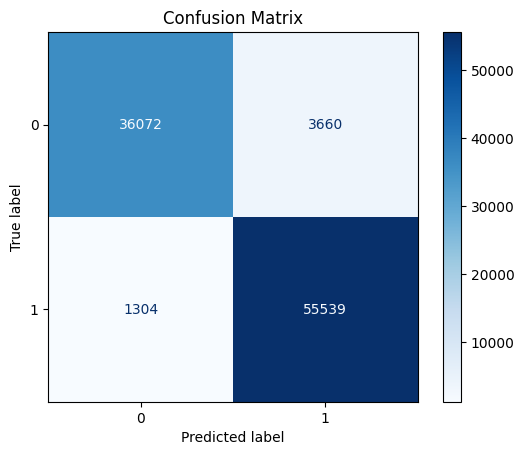


Classification Report:
              precision    recall  f1-score   support

 Non-Violent     0.9651    0.9079    0.9356     39732
     Violent     0.9382    0.9771    0.9572     56843

    accuracy                         0.9486     96575
   macro avg     0.9516    0.9425    0.9464     96575
weighted avg     0.9493    0.9486    0.9483     96575

Test Accuracy: 94.86%


In [12]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 모델 평가 함수 (테스트 데이터로 예측 및 평가 지표 출력)
def evaluate_model_with_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            person_counts = X_batch[:, :, -1]  # person_count가 마지막 feature에 있다고 가정
            for i, X_seq in enumerate(X_batch):
                # 사람이 없는 경우 (person_count == 0) 무조건 비폭행(0)으로 예측
                if (person_counts[i] == 0).all():
                    predicted = torch.tensor([0]).to(device)

                # 사람이 1명인 경우 (person_count == 1) 무조건 비폭행(0)으로 예측
                elif (person_counts[i] == 1).all():
                    predicted = torch.tensor([0]).to(device)

                # 사람이 2명 이상일 경우 모델로 예측
                else:
                    output = model(X_seq.unsqueeze(0).to(device))
                    _, predicted = torch.max(output, 1)

                all_preds.extend(predicted.cpu().numpy())  # 예측값 저장
                all_labels.append(y_batch[i].cpu().item())  # 실제 라벨 저장

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # 정밀도, 재현율, F1-Score 계산
    report = classification_report(all_labels, all_preds, target_names=['Non-Violent', 'Violent'], digits=4)
    print("\nClassification Report:")
    print(report)

    # 정확도 계산
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return cm

# 모델 평가 및 혼동 행렬 시각화
confusion_matrix = evaluate_model_with_metrics(model, test_loader)

In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
import copy
import random

# Seed 설정 함수
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# LSTM용 데이터셋 클래스 정의
class ViolenceDataset(Dataset):
    def __init__(self, data, seq_length=3):
        self.seq_length = seq_length

        # 문자열로 되어 있는 포즈 분류(target_person_label, closest_person_label)를 숫자로 인코딩
        label_encoder = LabelEncoder()
        data['target_person_label'] = label_encoder.fit_transform(data['target_person_label'])
        data['closest_person_label'] = label_encoder.fit_transform(data['closest_person_label'])

        # 비디오 파일 별로 데이터 그룹화
        self.grouped_data = data.groupby('video_filename').apply(lambda x: x.sort_values('frame_num', ascending=True)).reset_index(drop=True)

        # 결측치 제거
        self.grouped_data = self.grouped_data.dropna()  # NaN 값 제거

        # 필요한 컬럼들 제외
        self.scaler = StandardScaler()
        features = self.grouped_data.drop(columns=['video_filename', 'frame_num', 'final_label',
            'left_elbow_angle_1', 'right_elbow_angle_1', 'left_knee_angle_1', 'right_knee_angle_1',
            'left_shoulder_left_elbow_dist_1', 'right_shoulder_right_elbow_dist_1',
            'left_hip_left_knee_dist_1', 'right_hip_right_knee_dist_1',
            'left_elbow_angle_2', 'right_elbow_angle_2', 'left_knee_angle_2', 'right_knee_angle_2',
            'left_shoulder_left_elbow_dist_2', 'right_shoulder_right_elbow_dist_2',
            'left_hip_left_knee_dist_2', 'right_hip_right_knee_dist_2', 'person_count'])

        # StandardScaler로 입력 데이터 스케일링
        self.scaled_features = self.scaler.fit_transform(features)

        # 타겟은 final_label
        self.labels = self.grouped_data['final_label'].values
        self.person_count = self.grouped_data['person_count'].values  # 사람 수 저장

    def __len__(self):
        return len(self.grouped_data) - self.seq_length + 1

    def __getitem__(self, idx):
        # 사람이 0명 또는 1명일 경우 바로 비폭행으로 정답을 내림
        if (self.person_count[idx:idx + self.seq_length] < 2).all():
            return torch.tensor(self.scaled_features[idx:idx + self.seq_length], dtype=torch.float32), torch.tensor(0, dtype=torch.long)

        # 입력 데이터(X)와 타겟 데이터(y)를 seq_length 만큼 묶어서 반환
        X = self.scaled_features[idx:idx + self.seq_length]
        y = self.labels[idx + self.seq_length - 1]  # 마지막 프레임의 라벨을 타겟으로 사용
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# LSTM 모델 정의
class StackedLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(StackedLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers  # num_layers를 클래스 변수로 저장

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), 32).to(x.device)  # 초기 hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), 32).to(x.device)  # 초기 cell state

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스만 FC 레이어에 입력
        return out

# 데이터 로드 및 전처리
def load_data(file_path, batch_size=32, seq_length=5):
    df = pd.read_csv(file_path)

    # ViolenceDataset으로 변환
    dataset = ViolenceDataset(df, seq_length=seq_length)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader, dataset

# 모델 학습 함수
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, early_stopping_patience=3, accumulation_steps=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()  # Optimizer 초기화
        for i, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            output = model(X_batch)
            loss = criterion(output, y_batch)

            # Backward pass with gradient accumulation
            loss.backward()

            # Gradient accumulation step
            if (i + 1) % accumulation_steps == 0:  # Update weights every `accumulation_steps`
                optimizer.step()  # Update parameters
                optimizer.zero_grad()  # Clear gradients
            train_loss += loss.item()

        # Validation loop
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {avg_val_loss}")

        # 조기 종료 로직
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience = 0  # patience 리셋
        else:
            patience += 1
            if patience >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    # 가장 좋은 모델 가중치로 복원
    model.load_state_dict(best_model_wts)

# 모델 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 실행 환경 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 하이퍼파라미터 설정
params = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_epochs": 10,
    "early_stopping_patience": 3,
    "seq_length": 3,
    "hidden_size": 32,
    "num_layers": 2,  # num_layers 추가
}

# 데이터 로드
train_loader, train_dataset = load_data('/content/drive/MyDrive/논문주제/train_updated.csv', params["batch_size"], params["seq_length"])
val_loader, val_dataset = load_data('/content/drive/MyDrive/논문주제/val_updated.csv', params["batch_size"], params["seq_length"])
test_loader, test_dataset = load_data('/content/drive/MyDrive/논문주제/test_updated.csv', params["batch_size"], params["seq_length"])

# 모델 초기화 및 학습
input_size = train_dataset.scaled_features.shape[1]  # 입력 특성 수

model = StackedLSTMModel(input_size, params["hidden_size"], output_size=2, num_layers=params["num_layers"]).to(device)
train_model(model, train_loader, val_loader, num_epochs=params["num_epochs"], early_stopping_patience=params["early_stopping_patience"])

# 테스트 데이터로 모델 평가
evaluate_model(model, test_loader)

<ipython-input-13-815826031908>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped_data = data.groupby('video_filename').apply(lambda x: x.sort_values('frame_num', ascending=True)).reset_index(drop=True)
<ipython-input-13-815826031908>:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped_data = data.groupby('video_filename').apply(lambda x: x.sort_values('frame_num', ascending=True)).r

Epoch 1, Train Loss: 0.38130335764795287, Val Loss: 0.28616155846929453
Epoch 2, Train Loss: 0.2591770522770422, Val Loss: 0.22523387477068493
Epoch 3, Train Loss: 0.2216143976098372, Val Loss: 0.20453462012931753
Epoch 4, Train Loss: 0.19816761228118296, Val Loss: 0.17895079976487152
Epoch 5, Train Loss: 0.18214906784017665, Val Loss: 0.1633914119599176
Epoch 6, Train Loss: 0.16793614573594037, Val Loss: 0.16007606292759408
Epoch 7, Train Loss: 0.1576683131923604, Val Loss: 0.1490891262780285
Epoch 8, Train Loss: 0.14866709540739428, Val Loss: 0.133901195613281
Epoch 9, Train Loss: 0.13983454518535499, Val Loss: 0.13146297762838838
Epoch 10, Train Loss: 0.13138747554225508, Val Loss: 0.12284354343788169
Test Accuracy: 95.19%


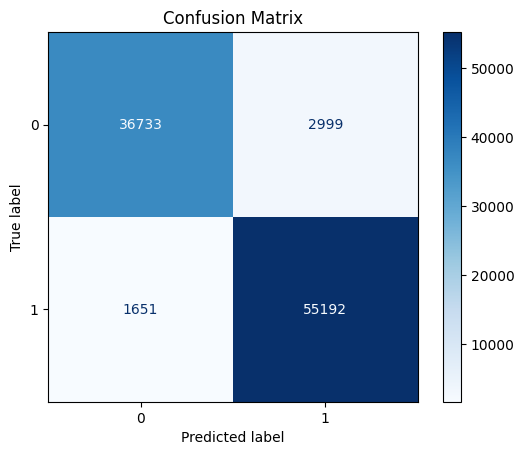


Classification Report:
              precision    recall  f1-score   support

 Non-Violent     0.9570    0.9245    0.9405     39732
     Violent     0.9485    0.9710    0.9596     56843

    accuracy                         0.9519     96575
   macro avg     0.9527    0.9477    0.9500     96575
weighted avg     0.9520    0.9519    0.9517     96575

Test Accuracy: 95.19%


In [14]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 모델 평가 함수 (테스트 데이터로 예측 및 평가 지표 출력)
def evaluate_model_with_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            person_counts = X_batch[:, :, -1]  # person_count가 마지막 feature에 있다고 가정
            for i, X_seq in enumerate(X_batch):
                # 사람이 없는 경우 (person_count == 0) 무조건 비폭행(0)으로 예측
                if (person_counts[i] == 0).all():
                    predicted = torch.tensor([0]).to(device)

                # 사람이 1명인 경우 (person_count == 1) 무조건 비폭행(0)으로 예측
                elif (person_counts[i] == 1).all():
                    predicted = torch.tensor([0]).to(device)

                # 사람이 2명 이상일 경우 모델로 예측
                else:
                    output = model(X_seq.unsqueeze(0).to(device))
                    _, predicted = torch.max(output, 1)

                all_preds.extend(predicted.cpu().numpy())  # 예측값 저장
                all_labels.append(y_batch[i].cpu().item())  # 실제 라벨 저장

    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)

    # 혼동 행렬 시각화
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # 정밀도, 재현율, F1-Score 계산
    report = classification_report(all_labels, all_preds, target_names=['Non-Violent', 'Violent'], digits=4)
    print("\nClassification Report:")
    print(report)

    # 정확도 계산
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return cm

# 모델 평가 및 혼동 행렬 시각화
confusion_matrix = evaluate_model_with_metrics(model, test_loader)

In [19]:
def check_missing_columns_for_two_people(df, dataset_name="Dataset"):
    """
    사람이 2명인 프레임에서 결측치가 있는 컬럼과 그 개수를 확인하는 함수.
    """
    # 사람이 2명인 (person_count == 2) 프레임 필터링
    two_people_df = df[df['person_count'] == 2]

    # 결측치가 있는 컬럼만 필터링
    missing_columns = two_people_df.isnull().sum()
    missing_columns = missing_columns[missing_columns > 0]  # 결측치가 있는 열만 선택

    # 결측치가 있는 컬럼과 그 개수를 출력
    if not missing_columns.empty:
        print(f"\n{dataset_name}에서 사람이 2명인 프레임 중 결측치가 있는 컬럼:")
        print(missing_columns)
    else:
        print(f"\n{dataset_name}에서 사람이 2명인 프레임에 결측치가 없습니다.")

# 각 데이터셋에 대해 결측치 있는 컬럼 확인
check_missing_columns_for_two_people(train_df, "Training Set")
check_missing_columns_for_two_people(val_df, "Validation Set")
check_missing_columns_for_two_people(test_df, "Test Set")


Training Set에서 사람이 2명인 프레임에 결측치가 없습니다.

Validation Set에서 사람이 2명인 프레임에 결측치가 없습니다.

Test Set에서 사람이 2명인 프레임에 결측치가 없습니다.
